In [ ]:
#author: Tobias Weis


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Pinhole camera model

Project a 3d worldpoint $[X,Y,Z]^T$ to 2d image plane $[u,v]^T$ using the pinhole camera model using a perspective transformation using homogenuous coordinates:

$$ s \left[\begin{matrix}u\\v\\1\end{matrix}\right] = \left[\begin{matrix}f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1\end{matrix}\right]\left[\begin{matrix}X\\Y\\Z\\1\end{matrix}\right]$$

<img src="pinhole_camera_model.jpg">

Very often, the camera is rotated or translated with respect to some known 3d world coordinates or 3d world frame. Incorporate the rotation and translation in to the matrix multiplication:

$$ s \left[\begin{matrix}u\\v\\1\end{matrix}\right] = \left[\begin{matrix}f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1\end{matrix}\right] \left[\begin{matrix}r_{11} & r_{12} & r_{13} & t_1\\r_{21} & r_{22} & r_{23} & t_2\\r_{31} & r_{32} & r_{33} & t_3\end{matrix}\right] \left[\begin{matrix}X\\Y\\Z\\1\end{matrix}\right]$$

where r are rotational, and t are translational parameters

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


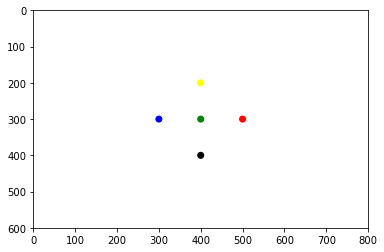

In [2]:
# implement simple projection

# specify some made-up camera parameters
f = [500,500]
c = [400,300]

p_ws = np.array([
    [1,0,5,1],
    [0,0,5,1],
    [-1,0,5,1],
    [0,1,5,1],
    [0,-1,5,1]
    ])

# define some colors for plotting
colors = ["red", "green", "blue", "black", "yellow", "pink"]

# implement simple projection
def project(Rt,f,c,p_w):
    M = np.array([[f[0],0,c[0]], [0,f[1],c[1]], [0,0,1]])
    p_i = np.dot(M,np.dot(Rt,p_w))
    return p_i/p_i[-1] # normalize homogenuous coordinates

def compute_Rt(angles, translations):
    X_rot = np.array([
        [1,0,0],
        [0,np.cos(angles[0]), -np.sin(angles[0])],
        [0, np.sin(angles[0]), np.cos(angles[0])]
    ])
    Y_rot = np.array([
        [np.cos(angles[1]), 0, np.sin(angles[1])],
        [0, 1,0],
        [-np.sin(angles[1]), 0, np.cos(angles[1])]
    ])
    Z_rot = np.array([
        [np.cos(angles[2]), -np.sin(angles[2]), 0],
        [np.sin(angles[2]), np.cos(angles[2]), 0],
        [0, 0, 1]
    ])
    ret = np.zeros((3,4))
    R = np.eye(3)
    R = np.dot(X_rot, R)
    R = np.dot(Y_rot, R)
    R = np.dot(Z_rot, R)
    ret[:3,:3] = R
    ret[:,3:] = np.array(translations).reshape(3,1)
    print(ret)
    return ret

# compute rotation matrix
angles = [np.radians(0),np.radians(0),np.radians(0)]
translations = [0,0,0]
Rt = compute_Rt(angles, translations)

# project all points
p_is = []
for p_w in p_ws:    
    p_is.append(project(Rt,f,c,p_w))
p_is = np.array(p_is)   

# plot
fig = plt.figure()
plt.scatter(p_is[:,0], p_is[:,1], c=colors[:len(p_is)])
plt.xlim((0,800))
plt.ylim((0,600))
plt.gca().invert_yaxis()
plt.show()

This simple technique allows to project points from 3d to 2d. In contrast to more advanced rendering techniques, be aware that there is no z-buffer, so the relative depth-order, and occlusions will get lost in this projection.

# Distortions

Any real camera that has a lense is subject to distortions introduced by the lense system.
Those distortions are usually modeled and corrected using a polynomial model introduced in [1].

<img src="distortion_brown.png">

This can be implemented "by foot", or we can use the readily available functions of OpenCV (or other packages)

[1] Brown, Duane C. (May 1966). "Decentering distortion of lenses" (PDF). Photogrammetric Engineering. 32 (3): 444–462.


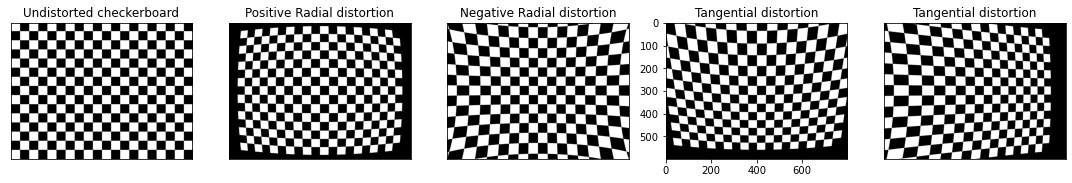

In [3]:
# create checkerboard image
def build_checkerboard(w,h,cw=40,ch=40):
    img = np.zeros((h,w))
    for idx,x in enumerate(range(0, img.shape[1],cw)):
        modifier = idx%2
        for idx2,y in enumerate(range(0,img.shape[0],ch)):
            if idx2 % 2 == 0:
                img[y:y+h,x:x+w] = 1-modifier
            else:
                img[y:y+h, x:x+w] = 0+modifier
    return img

cam_mat = np.array([[f[0],0,c[0]], [0,f[1],c[1]], [0,0,1]])

timg = build_checkerboard(800,600)

fig = plt.figure(figsize=(15,7))
fig.add_subplot(151)
plt.title("Undistorted checkerboard")
plt.imshow(timg, cmap='gray')

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

fig.add_subplot(152)
plt.title("Positive Radial distortion")
timg_undist = cv2.undistort(timg, cam_mat, np.array([0.2,0,0,0,0]))
plt.imshow(timg_undist, cmap='gray')

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

fig.add_subplot(153)
plt.title("Negative Radial distortion")
timg_undist = cv2.undistort(timg, cam_mat, np.array([-0.2,0,0,0,0]))
plt.imshow(timg_undist, cmap='gray')

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)


fig.add_subplot(154)
plt.title("Tangential distortion")
timg_undist = cv2.undistort(timg, cam_mat, np.array([0,0,0.1, 0, 0]))
plt.imshow(timg_undist, cmap='gray')

fig.add_subplot(155)
plt.title("Tangential distortion")
timg_undist = cv2.undistort(timg, cam_mat, np.array([0,0,0, 0.1, 0]))
plt.imshow(timg_undist, cmap='gray')

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()


## Determining distortion parameters

All it takes to calculate accurate coefficients for these distortion parameters is a set of images of a flat checkerboard.

There exist proven calibration toolboxes for Matlab (e.g. Bouguet toolbox [1]) and OpenCV (cv2.calibrateCamera [2]).

The principle trick is to set the world coordinate origin to the upper left chessboard corner, treating all points as lying on a plane (they do if you use a plain checkerboard), and calculate the homography and estimate the distortion coefficients. More details can be found in [3].

[1] http://www.vision.caltech.edu/bouguetj/calib_doc/

[2] https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html

[3] http://ais.informatik.uni-freiburg.de/teaching/ws09/robotics2/pdfs/rob2-08-camera-calibration.pdf

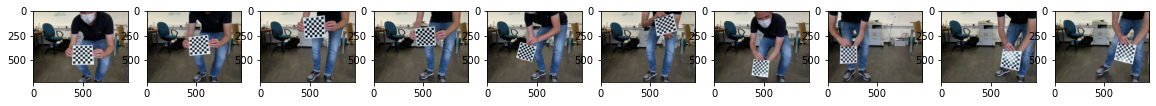

In [4]:
import os
images = [x for x in os.listdir() if ".jpg" in x]

fig = plt.figure(figsize=(20,10))

for idx,fname in enumerate(images):
    fig.add_subplot(1,10,idx+1)
    plt.imshow(cv2.imread(fname))

plt.show()

Now we need to find the chessboard-corners in those images, OpenCV provides functionality for this

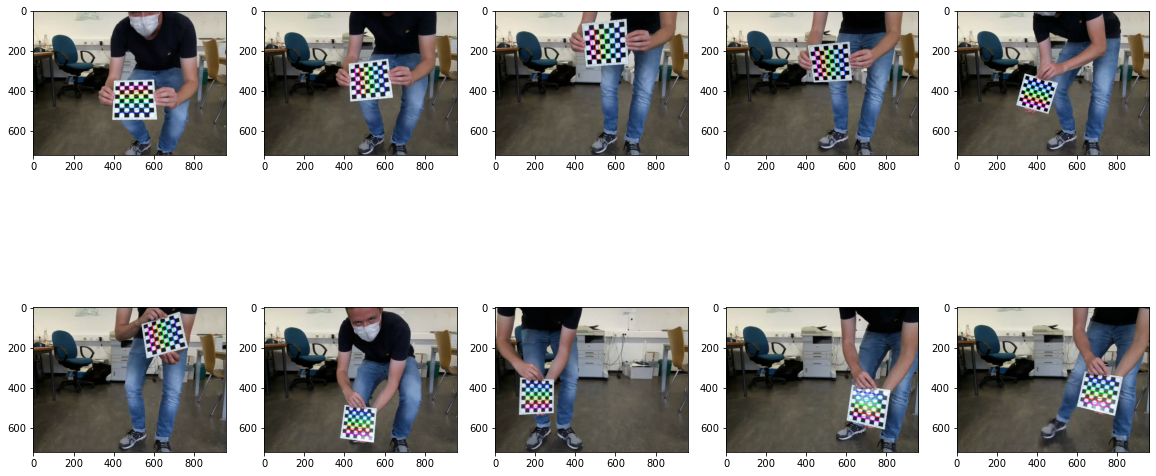

In [5]:
fig = plt.figure(figsize=(20,10))
chb_h = 7
chb_w = 7

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((chb_h*chb_w,3), np.float32)
objp[:,:2] = np.mgrid[0:chb_w,0:chb_h].T.reshape(-1,2)
objpoints = []
imgpoints = []

for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (chb_w,chb_h),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        cv2.cornerSubPix(gray,corners,(4,4),(-1,-1),criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (chb_w,chb_h), corners,ret)
        
        fig.add_subplot(2,5,idx+1)
        plt.imshow(img)
        
plt.show()

In [6]:
# and finally, we can estimate the camera parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (gray.shape[1],gray.shape[0]),None,None,flags=cv2.CALIB_RATIONAL_MODEL)
print(ret)
print("---------------")
print("Camera matrix")
print(mtx)
print("---------------")
print("Distortion coefficients")
print(dist)

0.21654144472511933
---------------
Camera matrix
[[892.14639795   0.         454.7607194 ]
 [  0.         886.81797677 380.95665023]
 [  0.           0.           1.        ]]
---------------
Distortion coefficients
[[ 2.99625357e+00 -3.11797147e+00  6.92313095e-03  3.69243110e-03
  -1.85019332e+02  2.90372389e+00 -1.90414387e+00 -1.88774069e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [19]:
test = np.zeros((1,3))

In [20]:
test*mtx

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])